In [34]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from PIL import Image

from rise.rise import RISE, IMAGES

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model = model.to(device)

# Load black box model for explanations
model = models.resnet50(weights=weights)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval().cuda()

# To use multiple GPUs
model = nn.DataParallel(model)


In [3]:
H, W = 224, 224
input_size = (H, W)

N = 5000      # number of masks (start small)
s = 7        # grid size
p = 0.12       # activation probability


test = RISE(model, (H, W))
test.generate_masks(N, s, p)

Generating filters: 100%|██████████| 5000/5000 [00:01<00:00, 3401.13it/s]


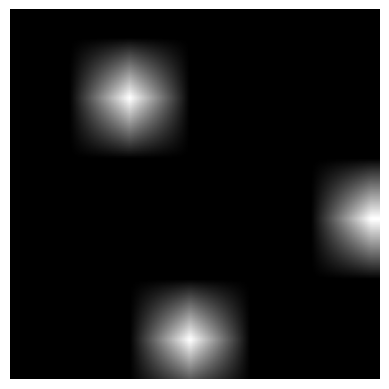

In [4]:
def draw_mask(mask):
    plt.imshow(mask.cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

draw_mask(test.masks[0])

In [58]:
img_path = IMAGES / "goldfish2.jpg"
img = Image.open(img_path).convert("RGB")
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

x.shape

torch.Size([1, 3, 224, 224])

In [59]:
C = 3
stack = test.masks * x    # (N, C, H, W)
stack.shape

torch.Size([5000, 3, 224, 224])

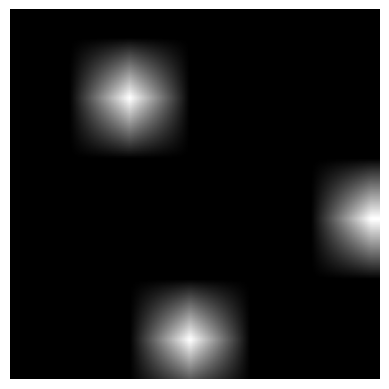

In [60]:
draw_mask(test.masks[0])

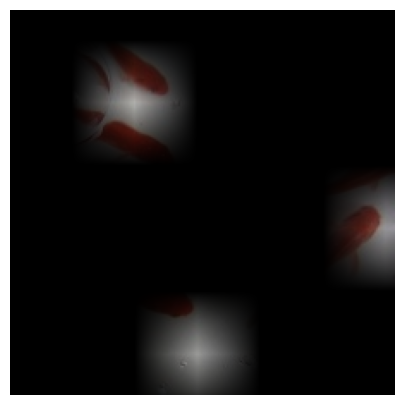

In [61]:
masked = stack[0].detach().cpu()   # (3, 224, 224)
# convert to HWC
masked = masked.permute(1, 2, 0).numpy()

# clip to valid range
masked = np.clip(masked, 0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(masked)
plt.axis("off")
plt.show()

In [62]:
stack[0:1].shape

torch.Size([1, 3, 224, 224])

In [63]:
test.masks[1]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0773, 0.0704, 0.0635],
         [0.0000, 0.0000, 0.0000,  ..., 0.0856, 0.0780, 0.0704],
         [0.0000, 0.0000, 0.0000,  ..., 0.0940, 0.0856, 0.0773],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')

In [64]:
outputs = []
with torch.no_grad():
    for i in range(0, N, 100):
        batch = stack[i:i + 100]
        outputs.append(model(batch))
outputs = torch.cat(outputs, dim=0) # (N, num_classes)

In [65]:
outputs.shape

torch.Size([5000, 1000])

In [66]:
test.masks.shape

torch.Size([5000, 1, 224, 224])

In [67]:
test.masks.view(N, H * W).shape

torch.Size([5000, 50176])

In [68]:
sal = torch.matmul(outputs.transpose(0, 1), test.masks.view(N, H * W))

In [69]:
sal.shape

torch.Size([1000, 50176])

In [70]:
CL = outputs.shape[1]
sal = sal.view((CL, H, W))

In [71]:
sal.shape

torch.Size([1000, 224, 224])

In [72]:
sal = sal / N / p

In [73]:
sal.shape

torch.Size([1000, 224, 224])

In [74]:
with torch.no_grad():
    logits = model(x.float())
    class_id = logits.argmax(dim=1).item()
class_id

1

In [75]:
logits[0,class_id]

tensor(0.3606, device='cuda:0')

In [76]:
sal_map = sal[class_id]

In [77]:
sal_map.shape

torch.Size([224, 224])

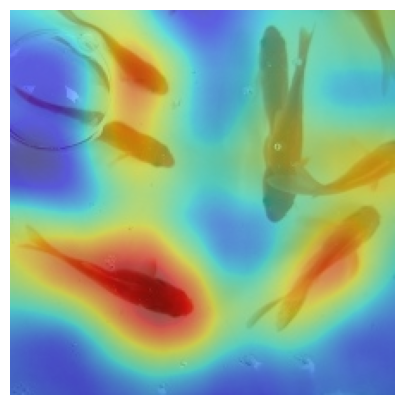

In [78]:
# image (RGB)
img_np = np.array(img) / 255.0

# saliency map
sal_map_numpy = sal_map.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(img_np)
plt.imshow(sal_map_numpy, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()
